In [3]:
#Mendownload dataset
!gdown 1PwzKTSqLUEKMqTPnII6D3GkHHd1Xtfba

#Melakukan unzip file dataset
!unzip -q lung_image_sets.zip --verbose

#Menghapus file zip
!rm -rf lung_image_sets.zip

Downloading...
From (original): https://drive.google.com/uc?id=1PwzKTSqLUEKMqTPnII6D3GkHHd1Xtfba
From (redirected): https://drive.google.com/uc?id=1PwzKTSqLUEKMqTPnII6D3GkHHd1Xtfba&confirm=t&uuid=81e10f42-219e-4768-9d93-e13dacee0281
To: /workspace/TelU-TugasAkhir/lung_image_sets.zip
100%|████████████████████████████████████████| 929M/929M [01:09<00:00, 13.4MB/s]


In [51]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import shutil   
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7

In [5]:
CWD = os.getcwd()
CWD

'/workspace/TelU-TugasAkhir'

In [6]:
extracted_folder_path = os.path.join(CWD, 'lung_image_sets')
source_files = os.listdir(extracted_folder_path)
print(source_files)

['lung_scc', 'lung_n', 'lung_aca']


In [7]:
base_dir = os.path.join(CWD, 'lung_image_sets')

def split_data(base_dir, train_ratio=0.72, val_ratio=0.2, test_ratio=0.08):
    
    sets = ['lung_aca', 'lung_n', 'lung_scc']
    
    destination = './splitted' 

    for set_name in sets:
        set_path = os.path.join(base_dir, set_name)
        images = os.listdir(set_path)

        # Split into train, val, and test
        train_images, temp_images = train_test_split(images, train_size=train_ratio, random_state=24)
        val_images, test_images = train_test_split(temp_images, test_size=test_ratio/(test_ratio + val_ratio),random_state=24)
        
        # Create directories if they don't exist
        for split in ['train', 'val', 'test']:
            split_dir = os.path.join(destination, split, set_name)
            os.makedirs(split_dir, exist_ok=True)
        
        # Move the images to their respective directories
        for image in train_images:
            shutil.copy(os.path.join(set_path, image), os.path.join(destination, 'train', set_name, image))
            print("train uwes")
        
        for image in val_images:
            shutil.copy(os.path.join(set_path, image), os.path.join(destination, 'val', set_name, image))
            print("val uwes")
        
        for image in test_images:
            shutil.copy(os.path.join(set_path, image), os.path.join(destination, 'test', set_name, image))
            print("test uwes")

    print("Data splitted into train, validation, and test sets.")
        
split_data(base_dir)

Data split into train, validation, and test sets.
Data split into train, validation, and test sets.
Data split into train, validation, and test sets.


In [52]:
def create_image_generators(train_dir, val_dir, test_dir, target_size=(224, 224), batch_size=32, preprocessing_func=None):
    # ImageDataGenerator without augmentation (for comparison)
    train_datagen_no_aug = ImageDataGenerator()

    # ImageDataGenerator with augmentation
    train_datagen_with_aug = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        preprocessing_function=preprocessing_func
    )
    
    # For validation and test sets, we do not apply augmentation
    val_test_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_func
    )
    
    # Flow images from directories
    train_generator_no_aug = train_datagen_no_aug.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    train_generator_with_aug = train_datagen_with_aug.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator_no_aug, train_generator_with_aug, val_generator, test_generator

# Pilih fungsi preprocessing yang sesuai dengan model
preprocess_input_func = efficientnet_preprocess

train_dir = os.path.join(CWD,'splitted/train')
val_dir = os.path.join(CWD,'splitted/val')
test_dir = os.path.join(CWD,'splitted/test')

Found 10800 images belonging to 3 classes.
Found 10800 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 1202 images belonging to 3 classes.


In [53]:
def create_model(base_model_class, input_shape):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = True  # Freeze the base model

    total_layers = len(base_model.layers)
    for layer in base_model.layers[(int(0.5 * total_layers)):]:
        layer.trainable =  False

    inputs = Input(shape=input_shape)
    # Tidak perlu preprocessing lagi di sini
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(3, activation='softmax')(x)

    model = Model(base_model.inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


efficientnet_b1 = create_model(EfficientNetB1, input_shape=(224, 224, 3))

27018416/27018416 [==============================] - 2s 0us/step


In [28]:
def create_callbacks(model_name, checkpoint_path, patience=3, reduce_lr_factor=0.5, reduce_lr_patience=2):
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)

    saving_path = os.path.join(checkpoint_path, f'model_{model_name}.h5')

    # ModelCheckpoint to save the best model based on validation accuracy
    checkpoint = ModelCheckpoint(
        filepath=saving_path,  # Path to save the model
        monitor='val_accuracy',    # Monitor validation accuracy
        save_best_only=True,       # Save the model only when val_accuracy improves
        mode='max',                # Maximize validation accuracy
        verbose=1                  # Show messages when saving
    )
    
    # EarlyStopping to stop training when the model stops improving
    early_stopping = EarlyStopping(
        monitor='val_loss',        # Monitor validation loss
        patience=patience,         # Stop after 'patience' epochs without improvement
        mode='min',                # Minimize validation loss
        restore_best_weights=True, # Restore the best weights after stopping
        verbose=1
    )
    
    # ReduceLROnPlateau to reduce the learning rate when a plateau is detected
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',        # Monitor validation loss
        factor=reduce_lr_factor,   # Factor by which to reduce learning rate
        patience=reduce_lr_patience, # How many epochs to wait before reducing
        mode='min',                # Minimize validation loss
        min_lr=1e-6,               # Lower bound on the learning rate
        verbose=1
    )
    
    # Return the list of callbacks
    return [checkpoint, early_stopping, reduce_lr]

# Define the path to save the best model
checkpoint_path = CWD + '/model/weights'

In [54]:
# Fungsi untuk melatih model dan menampilkan grafik
def train_and_plot(model, model_name, train_generator, validation_generator, callbacks, epochs=10):
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks= callbacks
    )

    # Create directories if they don't exist
    model_dir = os.path.join(CWD, 'model', 'saved_models')
    plot_dir = os.path.join(CWD, model_name)

    os.makedirs(model_dir, exist_ok=True)  # Ensure the model save directory exists
    os.makedirs(plot_dir, exist_ok=True)   # Ensure the plot directory exists

    # Plotting hasil
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Save the plot as an image in the respective folder
    plot_filename = os.path.join(plot_dir, f'{model_name}_training_plot.png')
    plt.savefig(plot_filename)  # Save the plot
    plt.show()

    # Save the model in the respective folder
    model_filename = os.path.join(model_dir, f'{model_name}.h5')
    model.save(model_filename)  # Save the trained model

    plt.show()
    return history, model

In [ ]:
def show_cm_and_classification_report(model, test_generator, model_name):
    # Define directory for saving images and reports
    img_dir = os.path.join(CWD, f'{model_name}')
    os.makedirs(img_dir, exist_ok=True)  # Ensure the directory exists

    # Get predictions from the model
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)

    # Get true labels
    y_true = test_generator.classes

    # Get class labels
    class_labels = list(test_generator.class_indices.keys())

    # Generate the classification report
    report = classification_report(y_true, y_pred, target_names=class_labels)

    # Print classification report to console
    print("Classification Report:\n", report)

    # Save classification report to a text file
    report_filename = os.path.join(img_dir, f'{model_name}_classification_report.txt')
    with open(report_filename, 'w') as f:
        f.write(report)

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Save the confusion matrix as an image
    cm_filename = os.path.join(img_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_filename)
    plt.show()

    return report_filename, cm_filename


In [ ]:
def load_best_model(model_path):
    return tf.keras.models.load_model(model_path)

In [ ]:
train_generator_no_aug, train_generator_with_aug, val_generator, test_generator = create_image_generators(
    train_dir=train_dir,
    val_dir=val_dir,
    test_dir=test_dir,
    target_size=(224, 224),  # Image size
    batch_size=128,           # Batch size
    preprocessing_func=preprocess_input_func  # Optional preprocessing function (e.g., for VGG16 or other models)
)

In [ ]:
# Get a batch of images from the non-augmented and augmented generators
images_no_aug, _ = next(train_generator_no_aug)
images_aug, _ = next(train_generator_with_aug)

# Plot the first 5 images from both non-augmented and augmented generators
plt.figure(figsize=(10, 10))

for i in range(5):
    # Non-augmented images
    plt.subplot(2, 5, i + 1)
    plt.imshow(images_no_aug[i].astype('uint8'))  # Convert to uint8 if needed
    plt.title("No Aug")
    plt.axis('off')

    # Augmented images
    plt.subplot(2, 5, i + 6)
    plt.imshow(images_aug[i].astype('uint8'))  # Convert to uint8 if needed
    plt.title("With Aug")
    plt.axis('off')

plt.tight_layout()
plt.show()

Epoch 1/10


2024-10-14 16:16:16.852711: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_19/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


85/85 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9367
Epoch 1: val_accuracy did not improve from 1.00000
85/85 [==============================] - 137s 2s/step - loss: 0.1543 - accuracy: 0.9367 - val_loss: 0.0974 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 2/10
85/85 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9863
Epoch 2: val_accuracy did not improve from 1.00000
85/85 [==============================] - 95s 1s/step - loss: 0.0367 - accuracy: 0.9863 - val_loss: 0.1774 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9932
Epoch 3: val_accuracy did not improve from 1.00000
85/85 [==============================] - 87s 1s/step - loss: 0.0208 - accuracy: 0.9932 - val_loss: 0.0200 - val_accuracy: 0.9930 - lr: 0.0010
Epoch 4/10
85/85 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9934
Epoch 4: val_accuracy did not improve from 1.00000
85/8

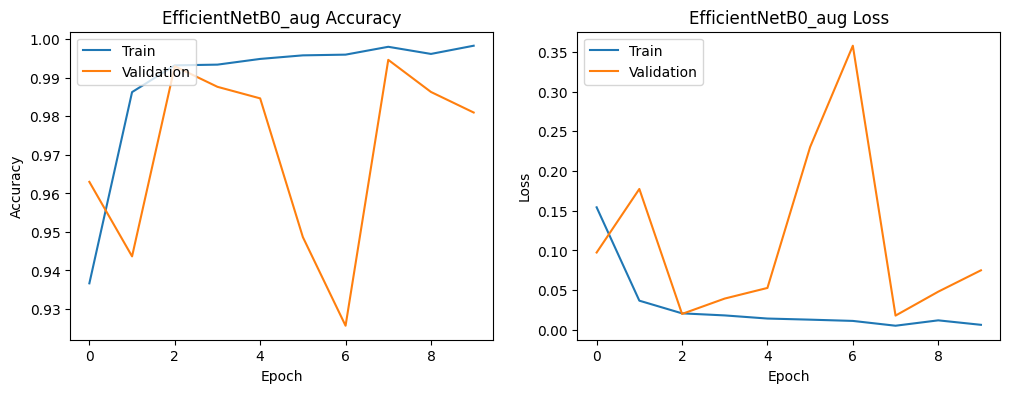

In [55]:
callbacks_eb0_aug = create_callbacks(
    model_name='EfficientNetB0_aug',
    checkpoint_path=checkpoint_path,
    patience=5,       
)

efficientnet_b0_aug = create_model(EfficientNetB0, input_shape=(224, 224, 3))

history_b0_aug, model_b0_aug = train_and_plot(efficientnet_b0_aug, 'EfficientNetB0_aug', train_generator_with_aug, val_generator, callbacks_eb0_aug)

In [ ]:
# Call the function after you have trained your model
report_file, cm_file = show_cm_and_classification_report(model_b0_aug, test_generator, 'EfficientNetB0_aug')

Epoch 1/10


2024-10-14 16:31:38.783588: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_20/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


85/85 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.9481
Epoch 1: val_accuracy did not improve from 0.99933
85/85 [==============================] - 59s 611ms/step - loss: 0.1315 - accuracy: 0.9481 - val_loss: 0.4057 - val_accuracy: 0.8917 - lr: 0.0010
Epoch 2/10
85/85 [==============================] - ETA: 0s - loss: 0.0264 - accuracy: 0.9902
Epoch 2: val_accuracy did not improve from 0.99933
85/85 [==============================] - 53s 617ms/step - loss: 0.0264 - accuracy: 0.9902 - val_loss: 0.0245 - val_accuracy: 0.9903 - lr: 0.0010
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9971
Epoch 3: val_accuracy did not improve from 0.99933
85/85 [==============================] - 51s 604ms/step - loss: 0.0098 - accuracy: 0.9971 - val_loss: 0.0233 - val_accuracy: 0.9920 - lr: 0.0010
Epoch 4/10
85/85 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9977
Epoch 4: val_accuracy did not improve from 0.99

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 49s 580ms/step - loss: 0.0012 - accuracy: 0.9995 - val_loss: 6.8208e-04 - val_accuracy: 0.9997 - lr: 0.0010


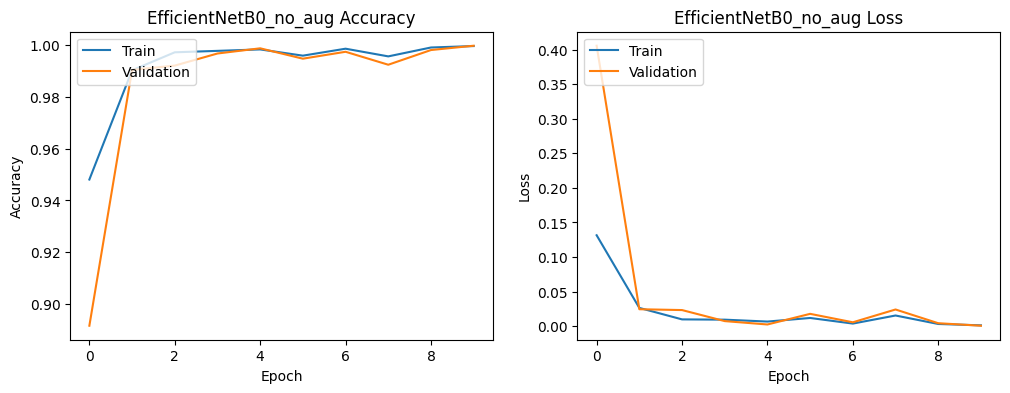

In [56]:
callbacks_eb0_no_aug = create_callbacks(
    model_name='EfficientNetB0_no_aug',
    checkpoint_path=checkpoint_path,
    patience=5,       
)

efficientnet_b0_no_aug = create_model(EfficientNetB0, input_shape=(224, 224, 3))

history_b0_no_aug, model_b0_no_aug = train_and_plot(efficientnet_b0_no_aug, 'EfficientNetB0_no_aug', train_generator_no_aug, val_generator, callbacks_eb0_no_aug)

In [ ]:
# Call the function after you have trained your model
report_file, cm_file = show_cm_and_classification_report(model_b0_no_aug, test_generator, 'EfficientNetB0_no_aug')

In [ ]:
train_generator_no_aug, train_generator_with_aug, val_generator, test_generator = create_image_generators(
    train_dir=train_dir,
    val_dir=val_dir,
    test_dir=test_dir,
    target_size=(240, 240),  # Image size
    batch_size=32,           # Batch size
    preprocessing_func=preprocess_input_func  # Optional preprocessing function (e.g., for VGG16 or other models)
)

In [ ]:
callbacks_eb1 = create_callbacks(
    model_name='EfficientNetB1',
    checkpoint_path=checkpoint_path,
    patience=5,       
)

efficientnet_b1 = create_model(EfficientNetB1, input_shape=(240, 240, 3))

history_b1, model_b1 = train_and_plot(efficientnet_b1, 'EfficientNetB1', train_generator_with_aug, val_generator, callbacks_eb1)

In [ ]:
# Call the function after you have trained your model
report_file, cm_file = show_cm_and_classification_report(model_b1, test_generator, 'EfficientNetB1')

In [57]:
# Grad-CAM implementation
def get_gradcam_model(model, last_conv_layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    return grad_model

def compute_gradcam(grad_model, img_array, last_conv_layer_name, pred_index=None):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        output = predictions[:, pred_index]

    grads = tape.gradient(output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    conv_outputs = conv_outputs.numpy()
    pooled_grads = pooled_grads.numpy()

    # Multiply each channel in the feature map array by "how important this channel is" with regard to the prediction
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)  # ReLU and normalize
    return heatmap


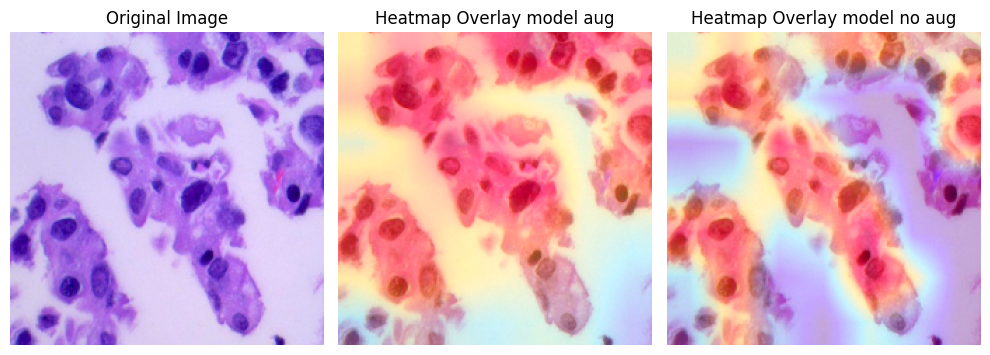

In [89]:
# Example usage of Grad-CAM
img = tf.keras.preprocessing.image.load_img('./splitted/test/lung_aca/lungaca1388.jpeg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# Get Grad-CAM model
grad_model_aug = get_gradcam_model(model_b0_aug, last_conv_layer_name='top_conv')
grad_model_no_aug = get_gradcam_model(model_b0_no_aug, last_conv_layer_name='top_conv')

# Generate Grad-CAM heatmap
heatmap_aug = compute_gradcam(grad_model_aug, img_array, last_conv_layer_name='top_conv')
heatmap_no_aug = compute_gradcam(grad_model_no_aug, img_array, last_conv_layer_name='top_conv')

# Rescale heatmap to a range of 0-255 for visualization
heatmap_aug = cv2.resize(heatmap_aug, (224, 224))
heatmap_aug = np.uint8(255 * heatmap_aug)

heatmap_no_aug = cv2.resize(heatmap_no_aug, (224, 224))
heatmap_no_aug = np.uint8(255 * heatmap_no_aug)

# # Apply heatmap to original image
heatmap_aug = cv2.applyColorMap(heatmap_aug, cv2.COLORMAP_JET)
heatmap_no_aug = cv2.applyColorMap(heatmap_no_aug, cv2.COLORMAP_JET)

# Ensure the original image is a numpy array and its values are scaled to 0-255
img = np.uint8(255 * (img_array[0] / np.max(img_array[0])))  # Normalize img to range [0, 255]

# Blend the heatmap and the original image
superimposed_aug_img = cv2.addWeighted(heatmap_aug, 0.3, img, 0.8, 0)  # Adjusted blending ratio
superimposed_no_aug_img = cv2.addWeighted(heatmap_no_aug, 0.3, img, 0.8, 0)  # Adjusted blending ratio

# Save the output image
cv2.imwrite('gradcam_output_aug.jpg', superimposed_aug_img)
cv2.imwrite('gradcam_output_no_aug.jpg', superimposed_no_aug_img)

# Plot both the original and heatmap superimposed images side by side
plt.figure(figsize=(10, 5))

# Show the original image
plt.subplot(1, 3, 1)
plt.imshow(img)  # Convert BGR to RGB for matplotlib display
plt.title("Original Image")
plt.axis('off')

# Show the superimposed heatmap on the right
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(superimposed_aug_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib display
plt.title("Heatmap Overlay model aug")
plt.axis('off')

# Show the superimposed heatmap on the right
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(superimposed_no_aug_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib display
plt.title("Heatmap Overlay model no aug")
plt.axis('off')

# Show the figure
plt.tight_layout()
plt.show()